## Installing packages

In [1]:
!pip install plotly

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


## Importing all the necessary packages

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
import sklearn
import janestreet
import os, sys
import gc
import math
import random
import pathlib
from sklearn.preprocessing import MinMaxScaler
from catboost import CatBoostClassifier
import cv2
import plotly.express as px
import plotly.figure_factory as ff
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Loading the dataset

In [3]:
train_df=pd.read_csv('../input/jane-street-market-prediction/train.csv')

In [4]:
print('Total number of entries in the train dataset are:', len(train_df))
train_df.head()

Total number of entries in the train dataset are: 2390491


date     weight    resp_1    resp_2    resp_3    resp_4      resp  \
0     0   0.000000  0.009916  0.014079  0.008773  0.001390  0.006270   
1     0  16.673515 -0.002828 -0.003226 -0.007319 -0.011114 -0.009792   
2     0   0.000000  0.025134  0.027607  0.033406  0.034380  0.023970   
3     0   0.000000 -0.004730 -0.003273 -0.000461 -0.000476 -0.003200   
4     0   0.138531  0.001252  0.002165 -0.001215 -0.006219 -0.002604   

   feature_0  feature_1  feature_2  ...  feature_121  feature_122  \
0          1  -1.872746  -2.191242  ...          NaN     1.168391   
1         -1  -1.349537  -1.704709  ...          NaN    -1.178850   
2         -1   0.812780  -0.256156  ...          NaN     6.115747   
3         -1   1.174378   0.344640  ...          NaN     2.838853   
4          1  -3.172026  -3.093182  ...          NaN     0.344850   

   feature_123  feature_124  feature_125  feature_126  feature_127  \
0     8.313583     1.782433    14.018213     2.653056    12.600292   
1     1.777472    -0.915458     2.831612    -1.417010     2.297459   
2     9.667908     5.542871    11.671595     7.281757    10.060014   
3     0.499251     3.033732     1.513488     4.397532     1.266037   
4     4.101145     0.614252     6.623456     0.800129     5.233243   

   feature_128  feature_129  ts_id  
0     2.301488    11.445807      0  
1    -1.304614     1.898684      1  
2     6.638248     9.427299      2  
3     3.856384     1.013469      3  
4     0.362636     3.926633      4  

[5 rows x 138 columns]

In [5]:
features_df = pd.read_csv('/kaggle/input/jane-street-market-prediction/features.csv', index_col = 0)
print('Total number of features are:', len(features_df))
features_df.head()


Total number of features are: 130


tag_0  tag_1  tag_2  tag_3  tag_4  tag_5  tag_6  tag_7  tag_8  \
feature                                                                    
feature_0  False  False  False  False  False  False  False  False  False   
feature_1  False  False  False  False  False  False   True   True  False   
feature_2  False  False  False  False  False  False   True   True  False   
feature_3  False  False  False  False  False  False   True  False   True   
feature_4  False  False  False  False  False  False   True  False   True   

           tag_9  ...  tag_19  tag_20  tag_21  tag_22  tag_23  tag_24  tag_25  \
feature           ...                                                           
feature_0  False  ...   False   False   False   False   False   False   False   
feature_1  False  ...   False   False   False   False   False   False   False   
feature_2   True  ...   False   False   False   False   False   False   False   
feature_3  False  ...   False   False   False   False   False   False   False   
feature_4   True  ...   False   False   False   False   False   False   False   

           tag_26  tag_27  tag_28  
feature                            
feature_0   False   False   False  
feature_1   False   False   False  
feature_2   False   False   False  
feature_3   False   False   False  
feature_4   False   False   False  

[5 rows x 29 columns]

# Exploratory Data Analysis

In [6]:
print("Properties",train_df.info())
print("Shape:",train_df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2390491 entries, 0 to 2390490
Columns: 138 entries, date to ts_id
dtypes: float64(135), int64(3)
memory usage: 2.5 GB
Properties None
Shape: (2390491, 138)


In [7]:
train_df.describe()

date        weight        resp_1        resp_2        resp_3  \
count  2.390491e+06  2.390491e+06  2.390491e+06  2.390491e+06  2.390491e+06   
mean   2.478668e+02  3.031535e+00  1.434969e-04  1.980749e-04  2.824183e-04   
std    1.522746e+02  7.672794e+00  8.930163e-03  1.230236e-02  1.906882e-02   
min    0.000000e+00  0.000000e+00 -3.675043e-01 -5.328334e-01 -5.681196e-01   
25%    1.040000e+02  1.617400e-01 -1.859162e-03 -2.655044e-03 -5.030704e-03   
50%    2.540000e+02  7.086770e-01  4.552665e-05  6.928179e-05  1.164734e-04   
75%    3.820000e+02  2.471791e+00  2.097469e-03  2.939111e-03  5.466336e-03   
max    4.990000e+02  1.672937e+02  2.453477e-01  2.949339e-01  3.265597e-01   

             resp_4          resp     feature_0     feature_1     feature_2  \
count  2.390491e+06  2.390491e+06  2.390491e+06  2.390491e+06  2.390491e+06   
mean   4.350201e-04  4.083113e-04  9.838565e-03  3.855776e-01  3.576875e-01   
std    3.291224e-02  2.693609e-02  9.999518e-01  2.559373e+00  2.477335e+00   
min   -5.987447e-01 -5.493845e-01 -1.000000e+00 -3.172026e+00 -3.093182e+00   
25%   -9.310415e-03 -7.157903e-03 -1.000000e+00 -1.299334e+00 -1.263628e+00   
50%    1.222579e-04  8.634997e-05  1.000000e+00 -1.870182e-05 -7.200577e-07   
75%    9.804649e-03  7.544347e-03  1.000000e+00  1.578417e+00  1.526399e+00   
max    5.113795e-01  4.484616e-01  1.000000e+00  7.442989e+01  1.480763e+02   

       ...   feature_121   feature_122   feature_123   feature_124  \
count  ...  2.320637e+06  2.390268e+06  2.390268e+06  2.374408e+06   
mean   ...  2.687757e-01  3.435523e-01  2.799973e-01  3.351537e-01   
std    ...  2.174238e+00  2.087842e+00  1.977643e+00  1.742587e+00   
min    ... -7.471971e+00 -5.862979e+00 -6.029281e+00 -4.080720e+00   
25%    ... -1.123252e+00 -1.114326e+00 -9.512009e-01 -9.133750e-01   
50%    ...  0.000000e+00  7.006233e-17  6.054629e-17  4.870826e-17   
75%    ...  1.342829e+00  1.405926e+00  1.308625e+00  1.228277e+00   
max    ...  1.107771e+02  4.812516e+01  1.276908e+02  6.514517e+01   

        feature_125   feature_126   feature_127   feature_128   feature_129  \
count  2.374408e+06  2.381638e+06  2.381638e+06  2.388570e+06  2.388570e+06   
mean   2.448752e-01  3.391778e-01  2.323809e-01  3.425608e-01  2.456182e-01   
std    2.242853e+00  2.534498e+00  1.795854e+00  2.307130e+00  1.765419e+00   
min   -8.136407e+00 -8.215050e+00 -5.765982e+00 -7.024909e+00 -5.282181e+00   
25%   -1.212124e+00 -1.452912e+00 -8.993050e-01 -1.278341e+00 -8.544535e-01   
50%   -2.558675e-16  1.015055e-16  5.419920e-17  8.563069e-17  4.869529e-17   
75%    1.409687e+00  1.767275e+00  1.111491e+00  1.582633e+00  1.125321e+00   
max    7.052807e+01  5.872849e+01  6.932221e+01  5.119038e+01  1.164568e+02   

              ts_id  
count  2.390491e+06  
mean   1.195245e+06  
std    6.900755e+05  
min    0.000000e+00  
25%    5.976225e+05  
50%    1.195245e+06  
75%    1.792868e+06  
max    2.390490e+06  

[8 rows x 138 columns]

In [8]:
print("Properties",features_df.info())
print("Shape:",features_df.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 130 entries, feature_0 to feature_129
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   tag_0   130 non-null    bool 
 1   tag_1   130 non-null    bool 
 2   tag_2   130 non-null    bool 
 3   tag_3   130 non-null    bool 
 4   tag_4   130 non-null    bool 
 5   tag_5   130 non-null    bool 
 6   tag_6   130 non-null    bool 
 7   tag_7   130 non-null    bool 
 8   tag_8   130 non-null    bool 
 9   tag_9   130 non-null    bool 
 10  tag_10  130 non-null    bool 
 11  tag_11  130 non-null    bool 
 12  tag_12  130 non-null    bool 
 13  tag_13  130 non-null    bool 
 14  tag_14  130 non-null    bool 
 15  tag_15  130 non-null    bool 
 16  tag_16  130 non-null    bool 
 17  tag_17  130 non-null    bool 
 18  tag_18  130 non-null    bool 
 19  tag_19  130 non-null    bool 
 20  tag_20  130 non-null    bool 
 21  tag_21  130 non-null    bool 
 22  tag_22  130 non-null    bool 
 23  tag_

In [9]:
features_df.describe()

tag_0  tag_1  tag_2  tag_3  tag_4  tag_5  tag_6  tag_7  tag_8  tag_9  \
count     130    130    130    130    130    130    130    130    130    130   
unique      2      2      2      2      2      2      2      2      2      2   
top     False  False  False  False  False  False  False  False  False  False   
freq      113    113    113    113    113    122     90    128    128    109   

        ... tag_19 tag_20 tag_21 tag_22 tag_23 tag_24 tag_25 tag_26 tag_27  \
count   ...    130    130    130    130    130    130    130    130    130   
unique  ...      2      2      2      2      2      2      2      2      2   
top     ...  False  False  False  False  False  False  False  False  False   
freq    ...    123    125    125    121     82    118    118    118    118   

       tag_28  
count     130  
unique      2  
top     False  
freq      118  

[4 rows x 29 columns]

## Training set

### Missing Data

In [10]:
train_df.isnull().sum()

date              0
weight            0
resp_1            0
resp_2            0
resp_3            0
               ... 
feature_126    8853
feature_127    8853
feature_128    1921
feature_129    1921
ts_id             0
Length: 138, dtype: int64

In [11]:
train_df.isna().head()

date  weight  resp_1  resp_2  resp_3  resp_4   resp  feature_0  feature_1  \
0  False   False   False   False   False   False  False      False      False   
1  False   False   False   False   False   False  False      False      False   
2  False   False   False   False   False   False  False      False      False   
3  False   False   False   False   False   False  False      False      False   
4  False   False   False   False   False   False  False      False      False   

   feature_2  ...  feature_121  feature_122  feature_123  feature_124  \
0      False  ...         True        False        False        False   
1      False  ...         True        False        False        False   
2      False  ...         True        False        False        False   
3      False  ...         True        False        False        False   
4      False  ...         True        False        False        False   

   feature_125  feature_126  feature_127  feature_128  feature_129  ts_id  
0        False        False        False        False        False  False  
1        False        False        False        False        False  False  
2        False        False        False        False        False  False  
3        False        False        False        False        False  False  
4        False        False        False        False        False  False  

[5 rows x 138 columns]

In [12]:
features_df.isna().head()

tag_0  tag_1  tag_2  tag_3  tag_4  tag_5  tag_6  tag_7  tag_8  \
feature                                                                    
feature_0  False  False  False  False  False  False  False  False  False   
feature_1  False  False  False  False  False  False  False  False  False   
feature_2  False  False  False  False  False  False  False  False  False   
feature_3  False  False  False  False  False  False  False  False  False   
feature_4  False  False  False  False  False  False  False  False  False   

           tag_9  ...  tag_19  tag_20  tag_21  tag_22  tag_23  tag_24  tag_25  \
feature           ...                                                           
feature_0  False  ...   False   False   False   False   False   False   False   
feature_1  False  ...   False   False   False   False   False   False   False   
feature_2  False  ...   False   False   False   False   False   False   False   
feature_3  False  ...   False   False   False   False   False   False   False   
feature_4  False  ...   False   False   False   False   False   False   False   

           tag_26  tag_27  tag_28  
feature                            
feature_0   False   False   False  
feature_1   False   False   False  
feature_2   False   False   False  
feature_3   False   False   False  
feature_4   False   False   False  

[5 rows x 29 columns]

In [13]:
fig=px.bar(x = train_df.isnull().sum().index,y = train_df.isnull().sum().values, labels = dict(x = "Attributes", y = "Number of Missing Values"), title= 'Missing Data')
fig.show()

### Tags

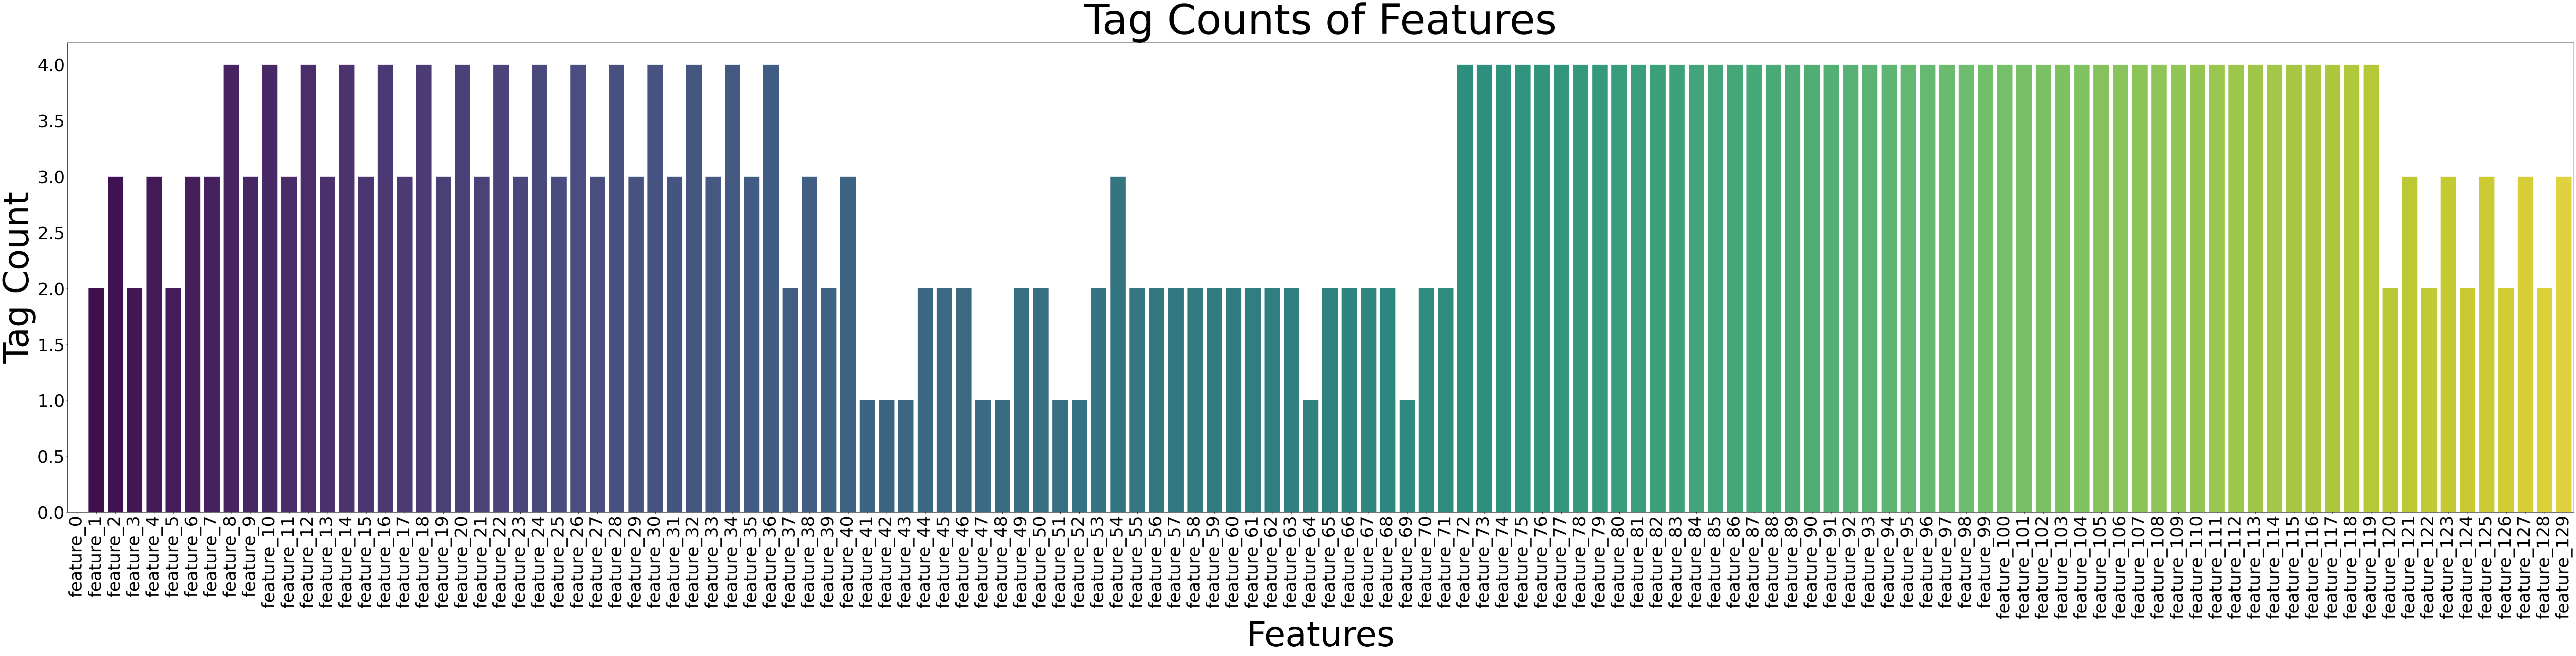

In [14]:
tags = features_df.sum(axis = 1)
tags_dict = {'Features' : tags.index.values, 'Tag Count' : tags.values}
tags_df = pd.DataFrame(tags_dict)
plt.figure(figsize = (130, 25))
plt.xlabel('Features', fontsize = 100)
plt.ylabel('Tag Count', fontsize = 100)
plt.title('Tag Counts of Features', fontsize = 120)
plt.xticks(rotation ='vertical', fontsize = 50)
plt.yticks(fontsize = 50)
sns.barplot(x = 'Features', y = 'Tag Count', data = tags_df,palette="viridis")
plt.show()
del tags_dict,tags_df

**ANALYSIS**
* feature_0 has no tags
* feature 79 to 119 all has 4 tags
* feature 7 to 36 have 3 and 4 tags periodically
* Similar trend between 2 to 7, 37 to 40, 120 to 129


**Feature_0 Analysis**

In [15]:
train_df['feature_0'].value_counts()

 1    1207005
-1    1183486
Name: feature_0, dtype: int64

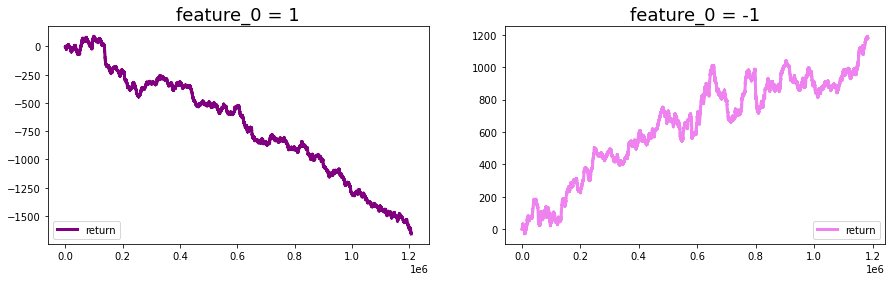

In [16]:
feature_0_is_plus_one  = train_df.query('feature_0 ==  1').reset_index(drop = True)
feature_0_is_minus_one = train_df.query('feature_0 == -1').reset_index(drop = True)
# the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
ax1.plot((pd.Series(feature_0_is_plus_one['resp']*feature_0_is_plus_one['weight']).cumsum()), lw=3, label='return', color="purple")
ax2.plot((pd.Series(feature_0_is_minus_one['resp']*feature_0_is_minus_one['weight']).cumsum()), lw=3, label='return', color="violet")
ax1.set_title ("feature_0 = 1", fontsize=18)
ax2.set_title ("feature_0 = -1", fontsize=18)
ax1.legend(loc="lower left")
ax2.legend(loc="lower right");

del feature_0_is_plus_one
del feature_0_is_minus_one
gc.collect();

**ANALYSIS:** when feature_0 is 1, plot shows negative slope while in contrast, when feature_0 is -1, plot shows positive slope. My guess is that feature_0 corresponds to Buy(1) and Sell(-1) or vice versa. So if we set action to 1 with feature_0 = 1 then we are selling and when we set action to 0 with feature_0 = -1, then we are buying. This makes sense since whether we are buying or selling we can still lose or gain profit.

### Weights

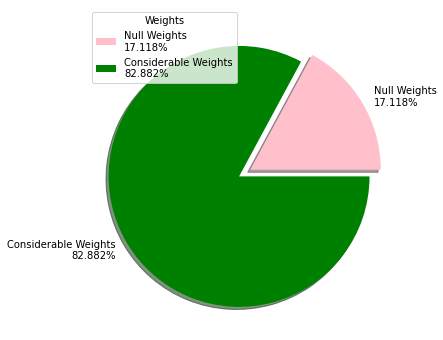

In [17]:

null_weights = (train_df['weight'] == 0).sum()
total_weights = len(train_df['weight'])
null_weights_per = null_weights / total_weights * 100
plt.figure(figsize = (15, 6))
plt.pie(((train_df.weight==0).mean(),(1-(train_df.weight==0).mean())), explode = (0, 0.1),shadow=True, labels=(f'Null Weights\n{round((train_df.weight==0).mean()*100,3)}%',f'Considerable Weights\n{round((1-(train_df.weight==0).mean())*100,3)}%'.format()), colors = ['pink', 'green'])
plt.legend(title='Weights')
plt.show()

**ANALYSIS:** dataset has too many NULL weights that can be removed for memory efficiency

In [18]:
date_weight_df = pd.DataFrame({'Date' : np.unique(train_df['date'].values), 'NULL_Weights' : train_df[train_df['weight'] == 0.0].groupby(['date']).size().values, 'NOT_NULL_Weights' : train_df[train_df['weight'] != 0.0].groupby(['date']).size().values})
date_weight_df.head()

Date  NULL_Weights  NOT_NULL_Weights
0     0          1017              4570
1     1          2216              7185
2     2           209                22
3     3          1312              5909
4     4          2611              7694

In [19]:
fig = plt.figure(figsize=(505, 100))

plt.xticks(rotation ='vertical', fontsize = 60)
plt.yticks(fontsize = 200)

ax = fig.add_subplot(111) 
ax2 = ax.twinx() 

date_weight_df.NOT_NULL_Weights.plot(kind='bar',color='green',ax=ax, position = 0)
date_weight_df.NULL_Weights.plot(kind='bar',color='pink', ax=ax2, position = 1)

ax.grid(None)
ax2.grid(None)

ax.set_ylabel('NOT NULL Weights', fontsize = 300)
ax2.set_ylabel('NULL Weights', fontsize = 300)
ax.set_xlabel('Time (in Days)',fontsize = 300)
fig.suptitle('NULL Weights Vs NOT NULL Weights per Day', fontsize = 450)

ax.set_xlim(-1, 505)

plt.show()

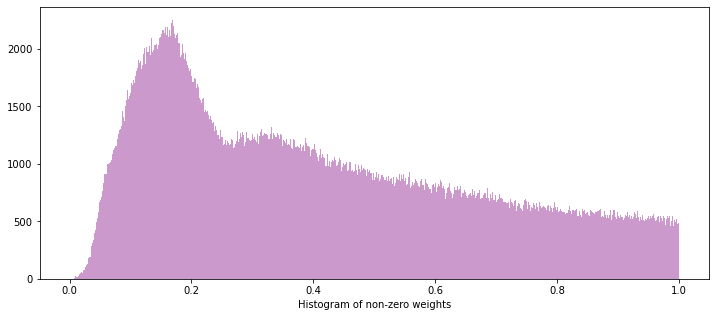

In [20]:
plt.figure(figsize = (12,5))
ax = sns.distplot(train_df['weight'], 
             bins=1000, 
             kde_kws={"clip":(0.001,1)}, 
             hist_kws={"range":(0.001,1)},
             color='purple', 
             kde=False);
values = np.array([rec.get_height() for rec in ax.patches])
norm = plt.Normalize(values.min(), values.max())
plt.xlabel("Histogram of non-zero weights", size=10)
plt.show();
del values
gc.collect();

**ANALYSIS** We can see that most weights are around 0.2 and we can see two 'peaks' which is around 0.2 and 0.3. Note that maximum weight was 167.29 represented by 1.0 on x-axis. 

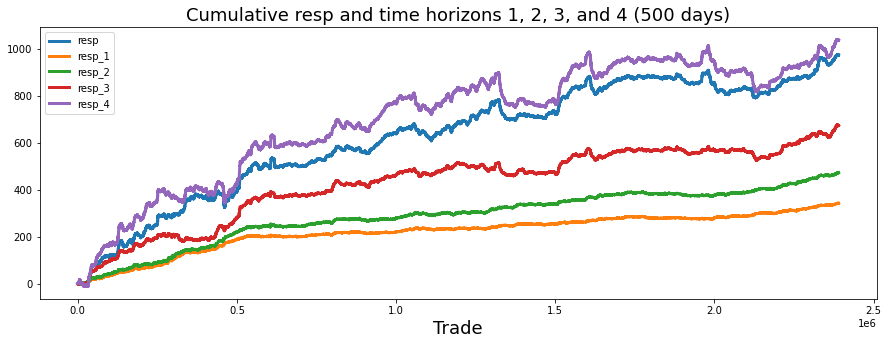

In [21]:
fig, ax = plt.subplots(figsize=(15, 5))
balance= pd.Series(train_df['resp']).cumsum()
resp_1= pd.Series(train_df['resp_1']).cumsum()
resp_2= pd.Series(train_df['resp_2']).cumsum()
resp_3= pd.Series(train_df['resp_3']).cumsum()
resp_4= pd.Series(train_df['resp_4']).cumsum()
ax.set_xlabel ("Trade", fontsize=18)
ax.set_title ("Cumulative resp and time horizons 1, 2, 3, and 4 (500 days)", fontsize=18)
balance.plot(lw=3)
resp_1.plot(lw=3)
resp_2.plot(lw=3)
resp_3.plot(lw=3)
resp_4.plot(lw=3)
plt.legend(loc="upper left")
del resp_1
del resp_2
del resp_3
del resp_4
gc.collect();

**ANALYSIS:** 
We can see that resp is closely related to resp_4 (blue and purple). Resp_1 and resp_2 also seem to be closely related but much much linear. Resp_3 seem to be in the middle, where the shape is closer to upper group but position is slightly closer to green and orange.


**POINT OF IMPORTANCE:** Weight and resp multiplied together represents a return on the trade.

3385

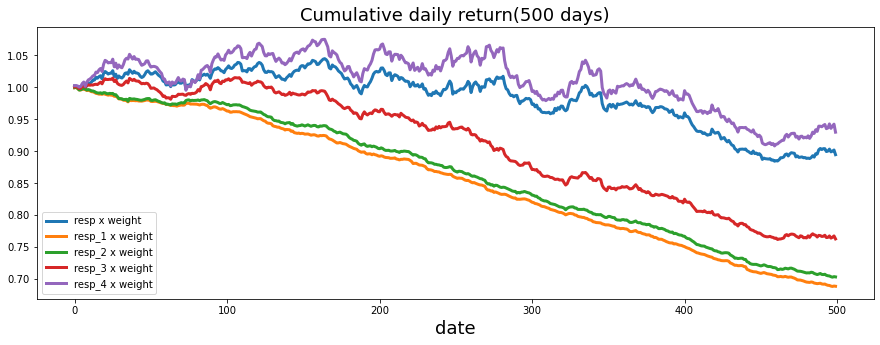

In [22]:
train_df['weight_resp']   = train_df['weight']* train_df['resp']
train_df['weight_resp_1'] = train_df['weight']* train_df['resp_1']
train_df['weight_resp_2'] = train_df['weight']* train_df['resp_2']
train_df['weight_resp_3'] = train_df['weight']* train_df['resp_3']
train_df['weight_resp_4'] = train_df['weight']* train_df['resp_4']

fig, ax = plt.subplots(figsize=(15, 5))
resp    = pd.Series(1+( train_df.groupby('date')['weight_resp'].mean())).cumprod()
resp_1  = pd.Series(1+( train_df.groupby('date')['weight_resp_1'].mean())).cumprod()
resp_2  = pd.Series(1+( train_df.groupby('date')['weight_resp_2'].mean())).cumprod()
resp_3  = pd.Series(1+( train_df.groupby('date')['weight_resp_3'].mean())).cumprod()
resp_4  = pd.Series(1+( train_df.groupby('date')['weight_resp_4'].mean())).cumprod()
ax.set_xlabel ("Day", fontsize=18)
ax.set_title ("Cumulative daily return(500 days)", fontsize=18)
resp.plot(lw=3, label='resp x weight')
resp_1.plot(lw=3, label='resp_1 x weight')
resp_2.plot(lw=3, label='resp_2 x weight')
resp_3.plot(lw=3, label='resp_3 x weight')
resp_4.plot(lw=3, label='resp_4 x weight')
plt.legend(loc="lower left")
del resp_1
del resp_2
del resp_3
del resp_4
gc.collect()

**ANALYSIS:** we can see that there were 'bigger' gains in the beginning and as time approach 500, the gain becomes smaller. In conclusion, the earlier trades are much bigger but we don't know what it's going to be like in our competition test set.

## Features

### Visualization

**Correlation Between Features**

In [23]:
corr = train_df.iloc[:, 7 : 137].corr()
px.imshow(corr, labels = dict(x = "Features", y = "Features"), width = 1000, height = 1000, title = "Correlation between Features",color_continuous_scale='algae')

**ANALYSIS:** Features seem to be forming clusters in the above correlation matrix. Features 17 to 26, 27 to 36, and 120 to 129 are some of the many examples shown. These are positively inclined to eachother. In a cluster, the intra cluster distance is lower than the inter cluster distance. Similarly, certain features are clearly negatively related to other features. Amongst the neutral grid, the postive and negative associations stand out!

**Correlation Between features and resps**

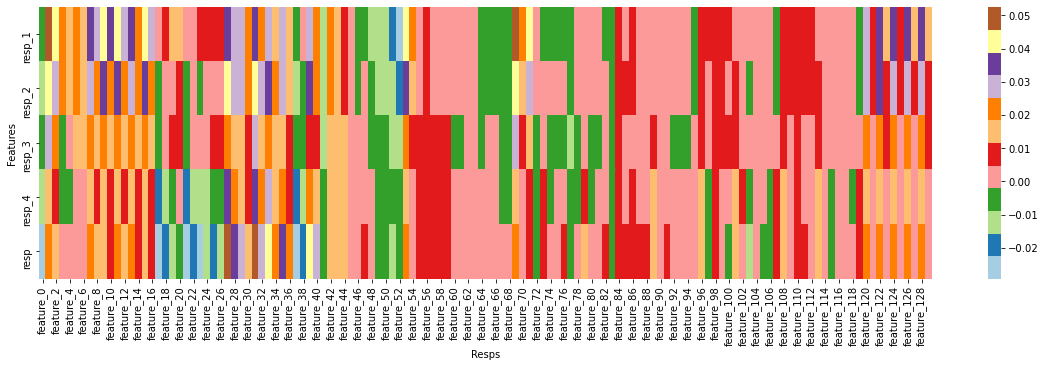

In [24]:
plt.figure(figsize = (20, 5))
fig = sns.heatmap(train_df.corr().iloc[2 : 7, 7 : -6], cmap = 'Paired')
fig.set(xlabel = 'Resps', ylabel = 'Features')
plt.show()

**ANALYSIS:** Features are either postively, negatively, or neutrally correlated to Resps. A pattern can be observed in the above heatmap which allows us to explore and dig deeper into their distributions. All the greens indicate negative association, blues indicate very negative association, reds indicate no association, oranges indicate positive association, purples, yellow, and brown indicate increasingly postive association in order.

**Correlation matrix is really large and confusing but there are clearly some patterns. I will cut it in parts for easier understanding and compare it to features dataframe.**

In [25]:
def show_corr_heatmap(df, method="pearson", width=10, calc_corr=False, annot=True):
    
    if calc_corr == True:
        if method == "MI":
            corr = MI_correlations(df)
        else:
            corr = df.corr(method)
    else:
        corr = df
        
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(width, width))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=annot, fmt=".2f")
    
    if calc_corr == True:
        return corr


def MI_correlations(df):
    corrs = {}
    for col_init in df.columns:
        corrs[col_init] = {}
        for col_corr in df.columns:
            if col_init != col_corr:
                corrs[col_init][col_corr] = calc_MI(df[col_init], df[col_corr])

    return pd.DataFrame(corrs)

def calc_MI(col_init, col_corr):
    
    if col_init.dtype == np.object:
        col_init = col_init.astype('category').cat.codes
    elif col_init.dtype.name == "category":
        col_init = col_init.cat.codes
        
    if col_corr.dtype == np.object:
        col_corr = col_corr.astype('category').cat.codes
    elif col_corr.dtype.name == "category":
        col_corr = col_corr.cat.codes

    mi = mutual_info_score(col_init, col_corr)

    return mi

**Features 0-50**

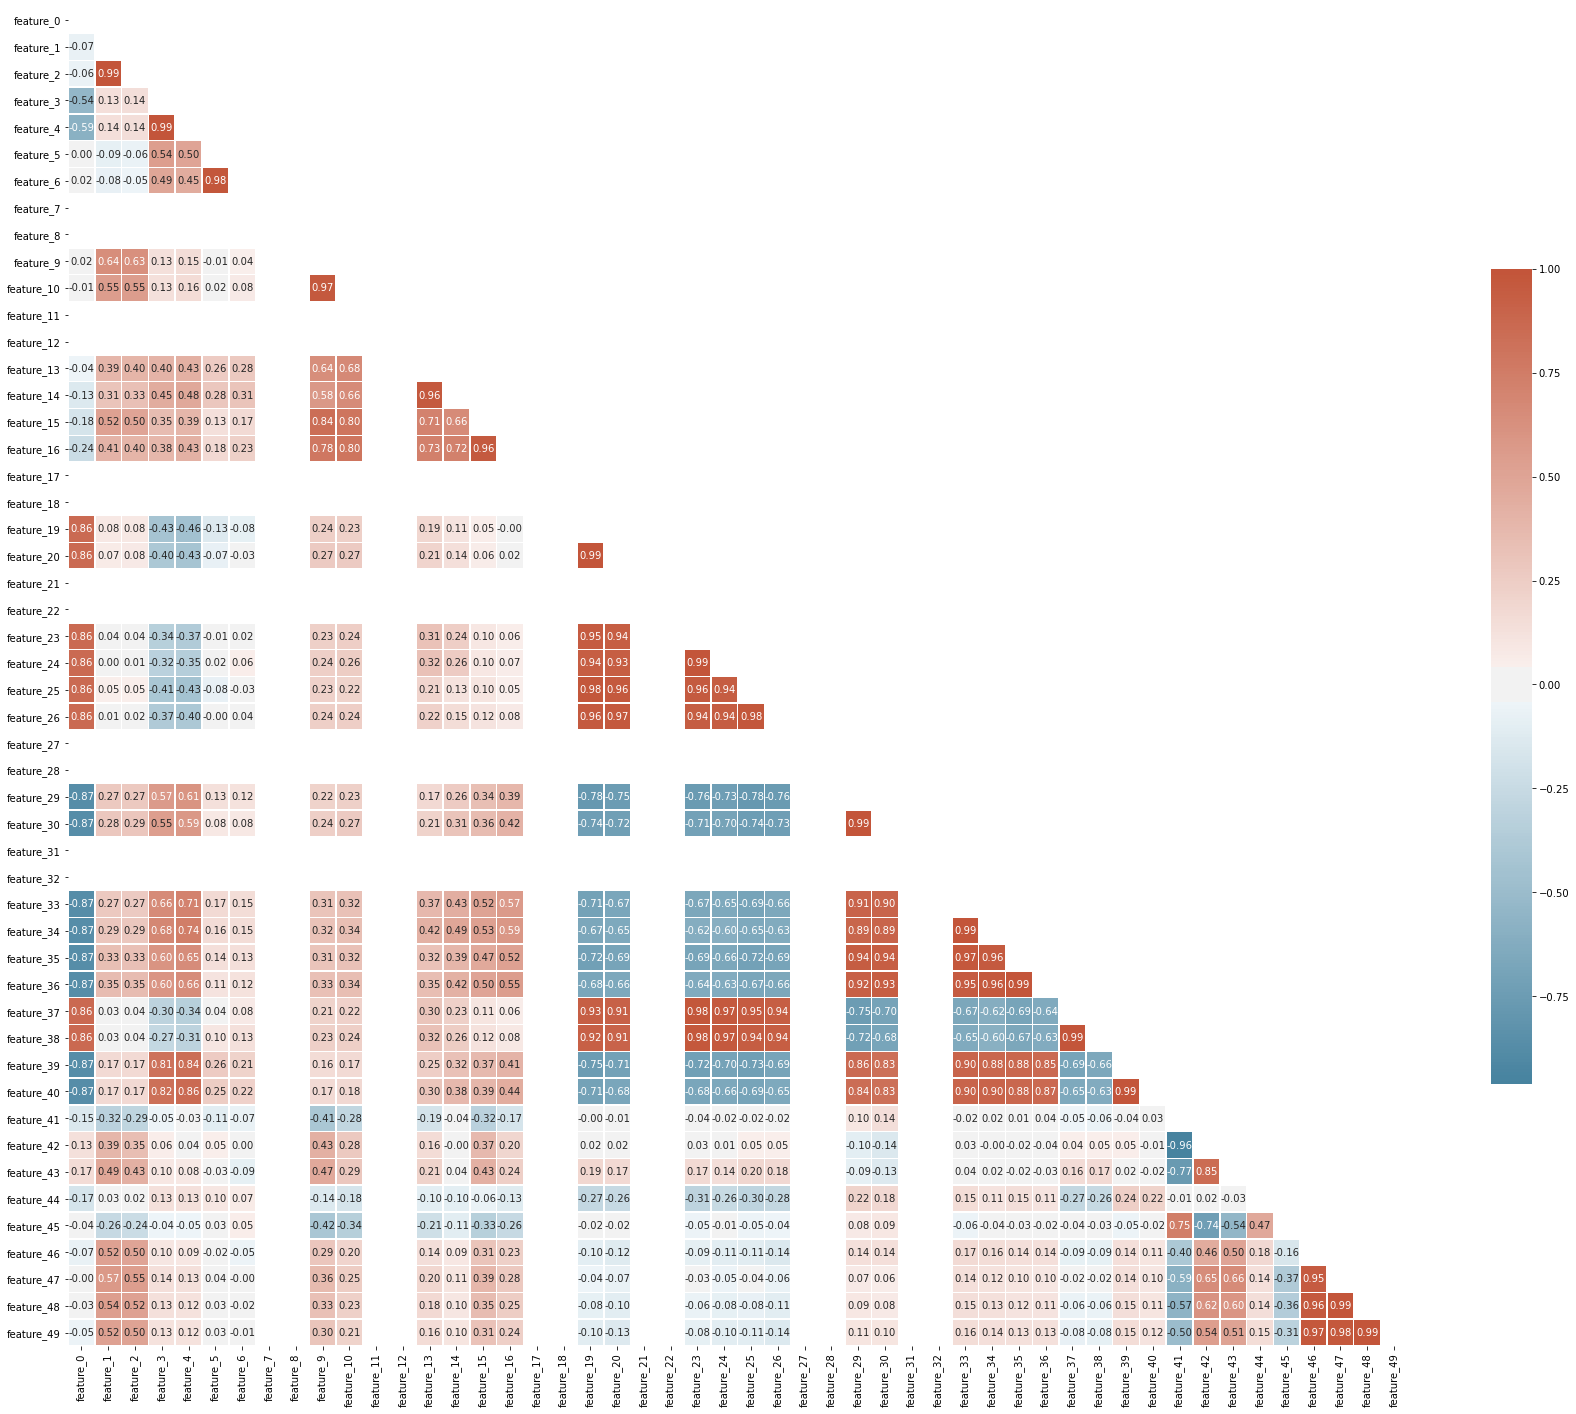

In [26]:
unnamed_features = [x for x in train_df.columns if "feature" in x]
corr_matrix = show_corr_heatmap(train_df[unnamed_features].iloc[0:50, 0:50], method="spearman", width=30, calc_corr=True, annot=True)

**Features 51-100**

43656

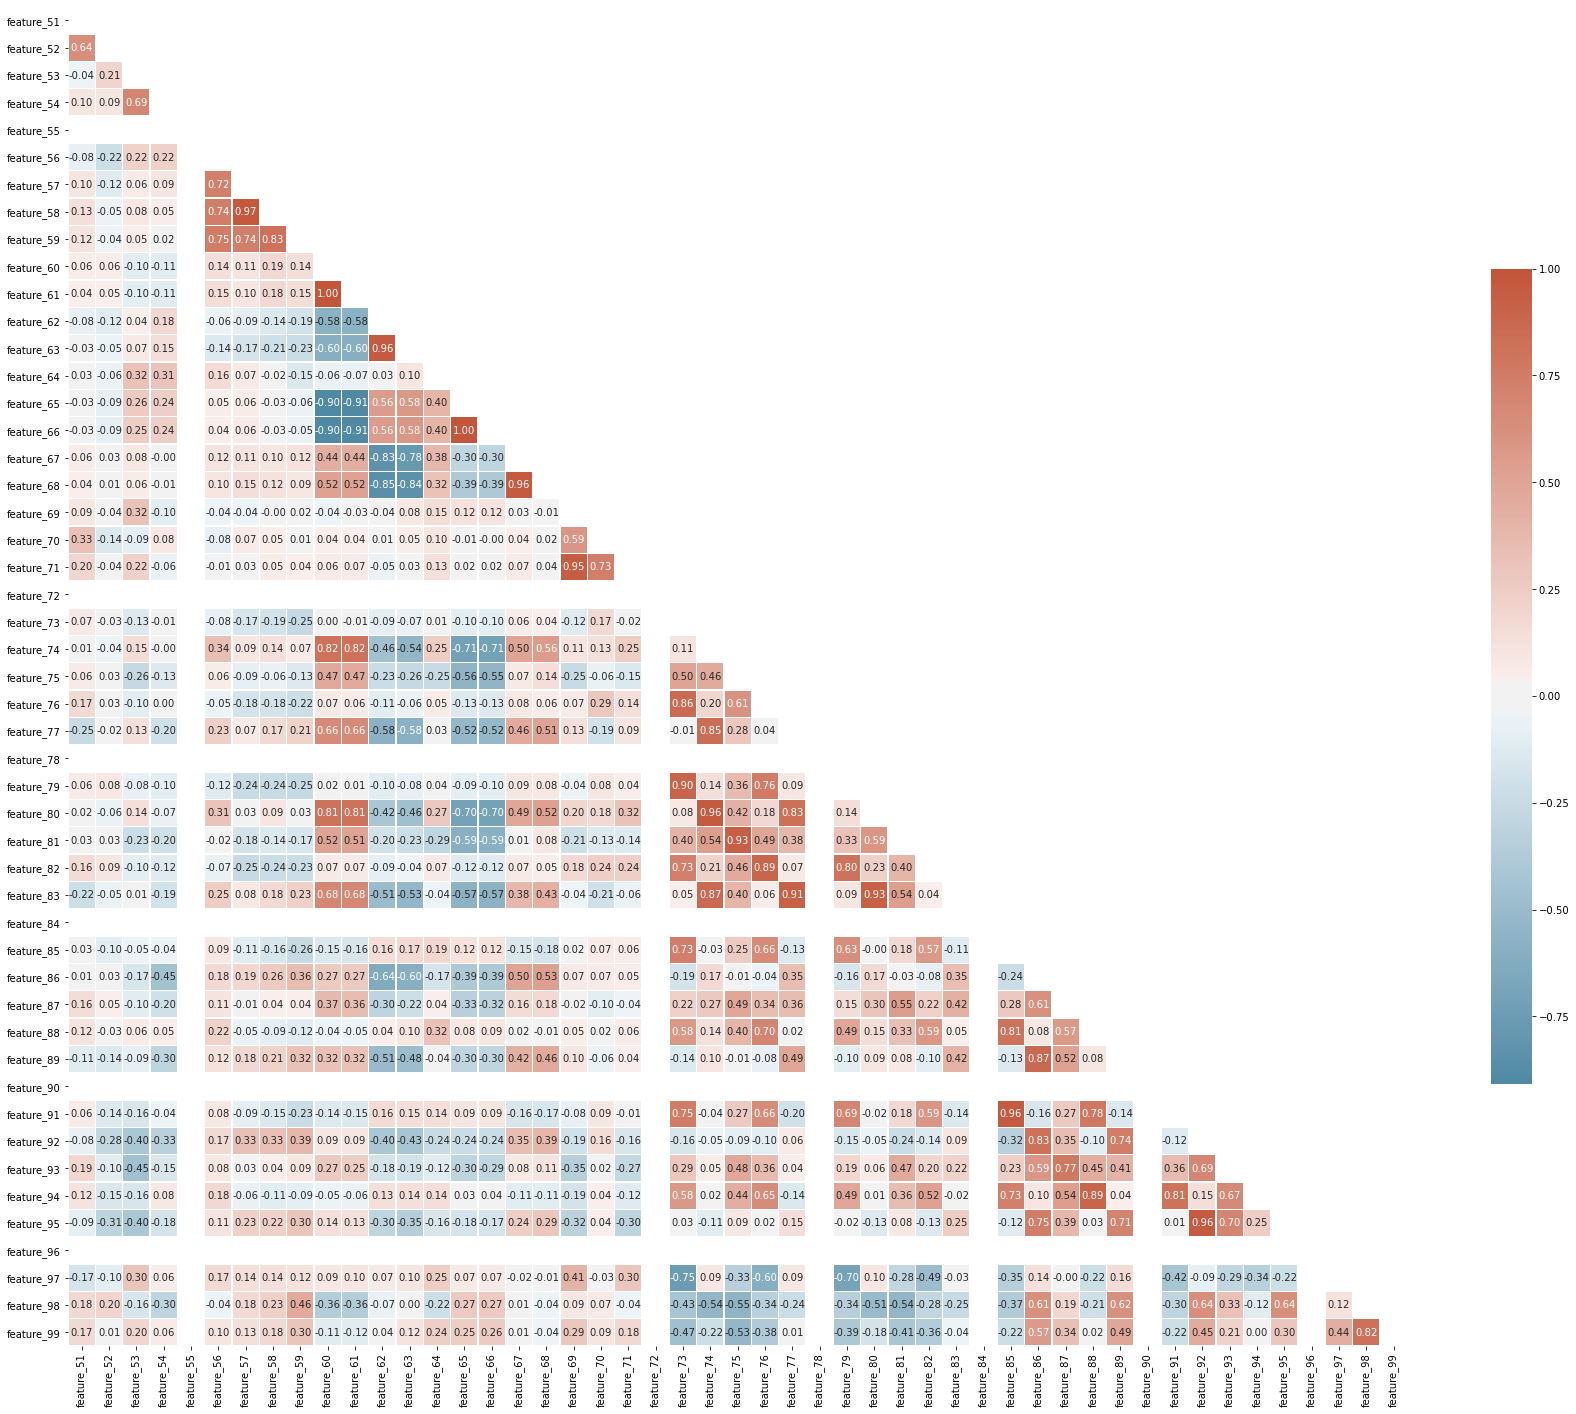

In [27]:
corr_matrix = show_corr_heatmap(train_df[unnamed_features].iloc[51:100, 51:100], method="spearman", width=30, calc_corr=True, annot=True)
gc.collect()

**ANALYSIS:** Features 73-95 are highly correlated. Features 85-95 are closely related that they may show linear relationship.

**Features 110-120**

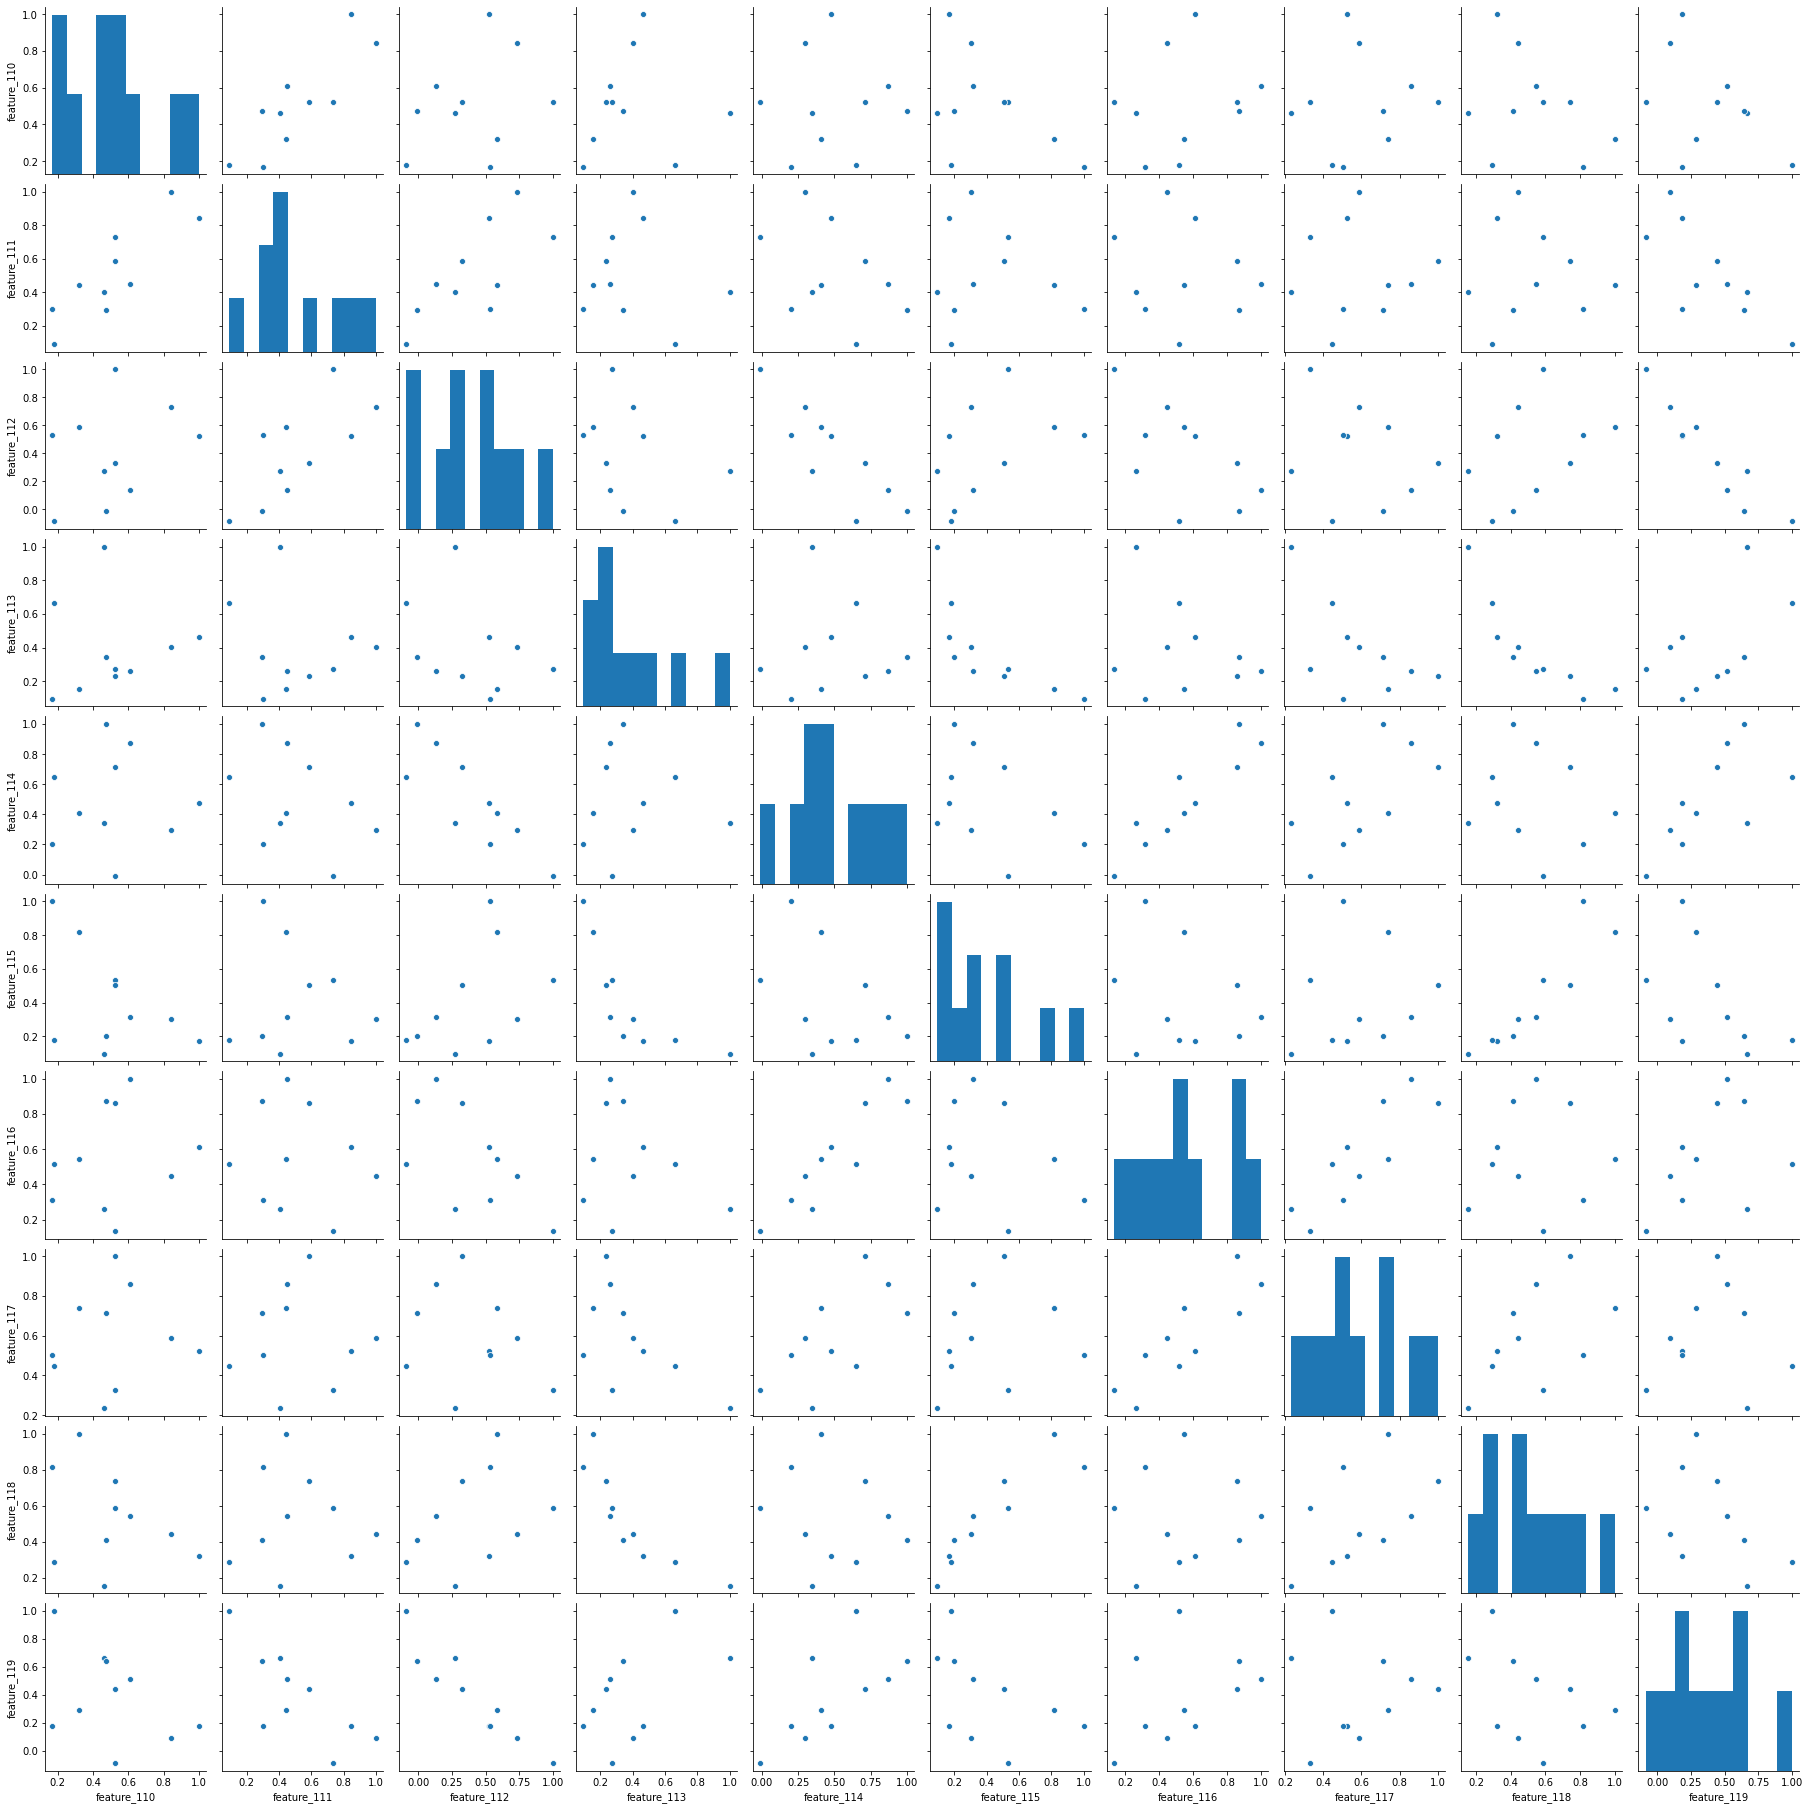

In [28]:
sns.pairplot(corr.iloc[110 : 120, 110 : 120])
plt.show()

**Features 120-130**

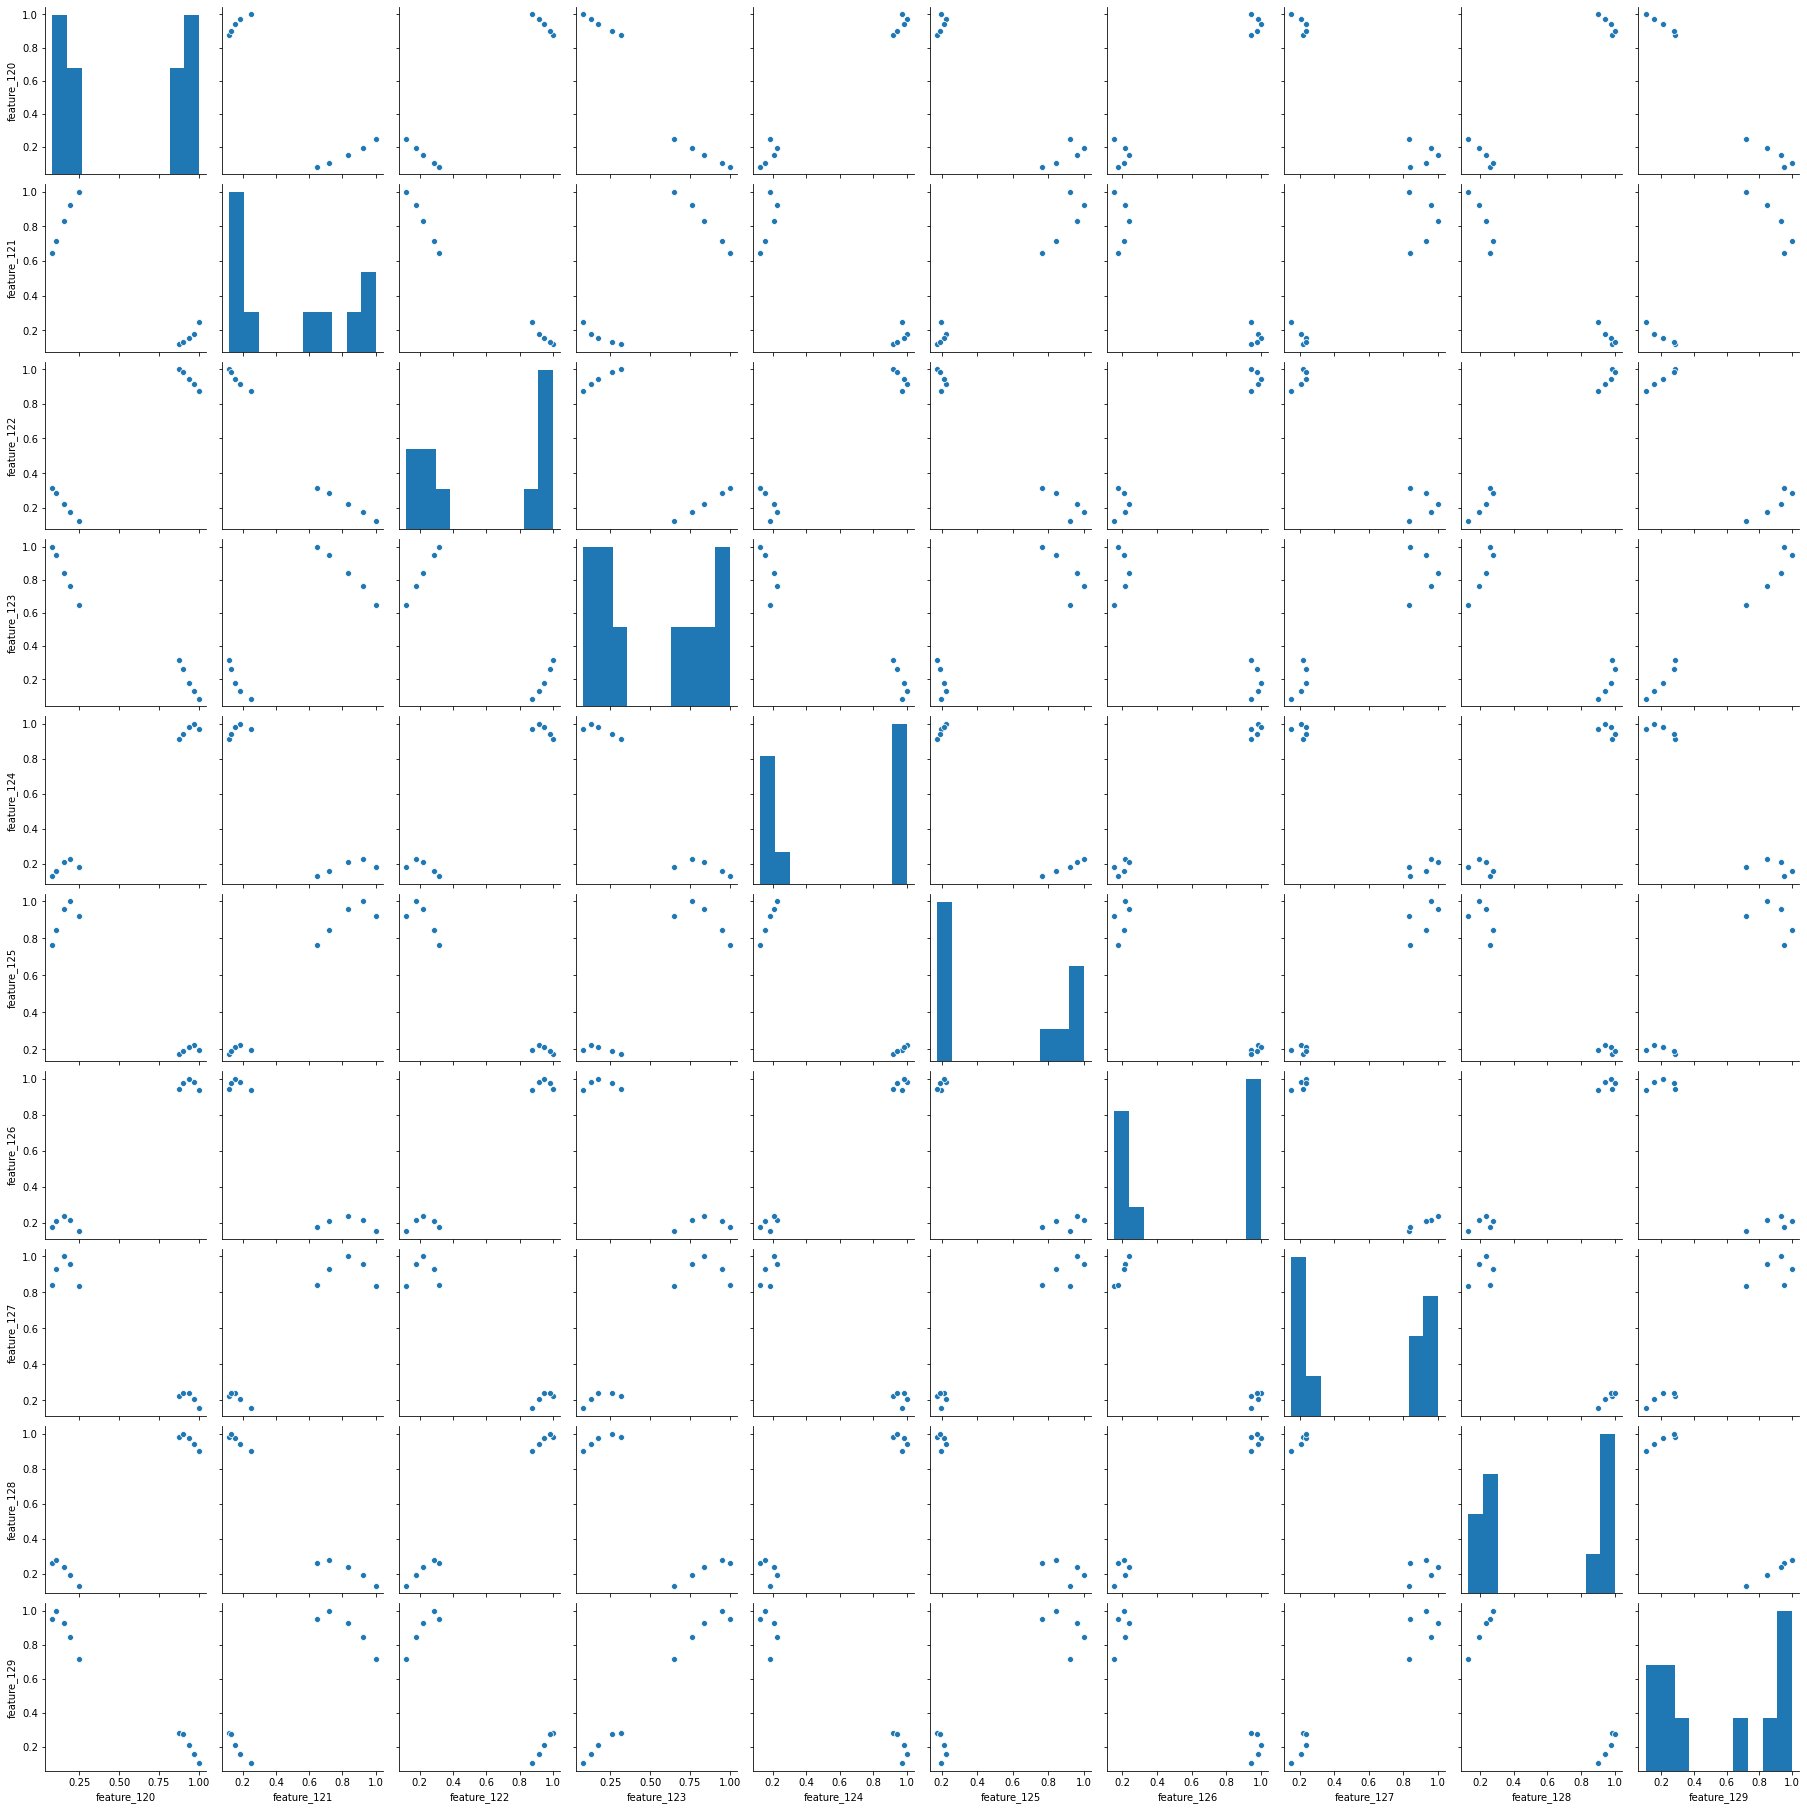

In [29]:
sns.pairplot(corr.iloc[120 : 130, 120 : 130])
plt.show()

**Features with resps**

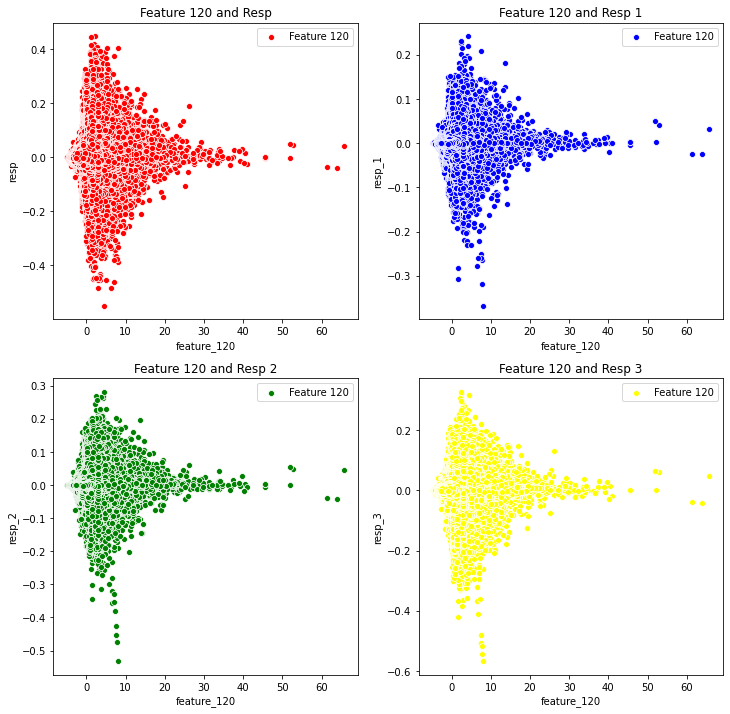

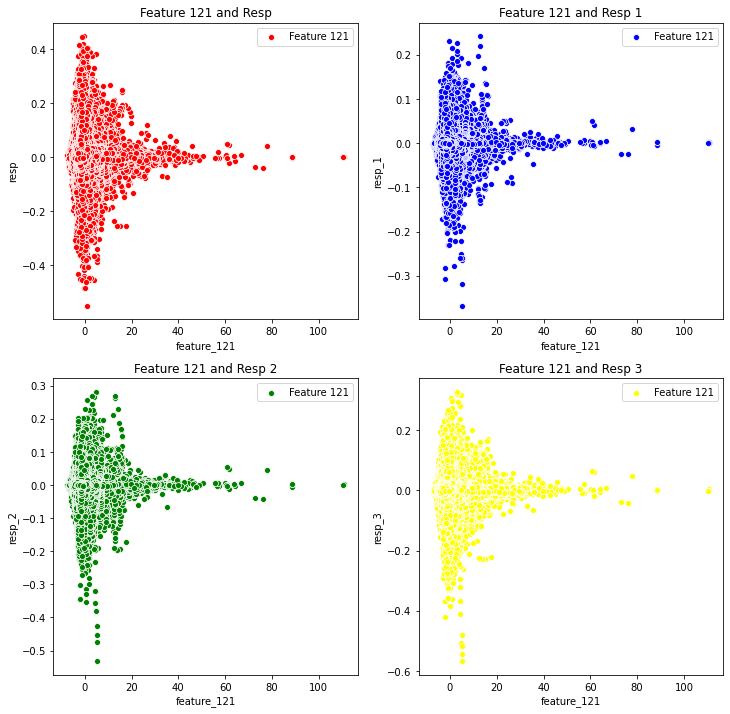

247576

In [30]:
for i in range(120, 122):

    fig, axes = plt.subplots(2, 2, figsize=(12,12))

    sns.scatterplot(data = train_df, x = f"feature_{str(i)}", y = "resp", ax = axes[0, 0], color = 'red')
    axes[0,0].set_title(f"Feature {str(i)} and Resp", fontsize = 12)
    axes[0,0].legend(labels=[f'Feature {str(i)}'])

    sns.scatterplot(data = train_df, x = f"feature_{str(i)}", y = "resp_1", ax = axes[0, 1], color = 'blue')
    axes[0,1].set_title(f"Feature {str(i)} and Resp 1", fontsize = 12)
    axes[0,1].legend(labels=[f'Feature {str(i)}'])

    sns.scatterplot(data = train_df, x = f"feature_{str(i)}", y = "resp_2", ax = axes[1, 0], color = 'green')
    axes[1,0].set_title(f"Feature {str(i)} and Resp 2", fontsize = 12)
    axes[1,0].legend(labels=[f'Feature {str(i)}'])

    sns.scatterplot(data = train_df, x = f"feature_{str(i)}", y = "resp_3", ax = axes[1, 1], color = 'yellow')
    axes[1,1].set_title(f"Feature {str(i)} and Resp 3", fontsize = 12)
    axes[1,1].legend(labels=[f'Feature {str(i)}'])
    
    plt.show()
gc.collect()

### ts_ids

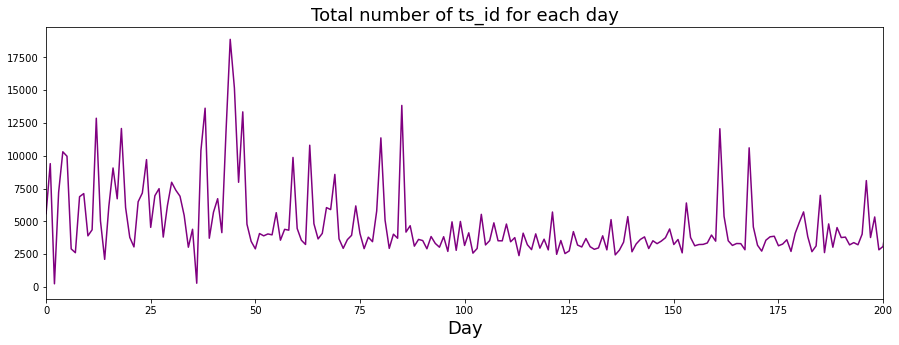

3402

In [31]:
trades_per_day = train_df.groupby(['date'])['ts_id'].count()
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(trades_per_day, color="purple")
ax.set_xlabel ("Day", fontsize=18)
ax.set_title ("Total number of ts_id for each day", fontsize=18)
ax.set_xlim(xmin=0)
ax.set_xlim(xmax=200)
plt.show()
del trades_per_day
gc.collect()

# Preprocessing

In [32]:
features = [col for col in list(train_df.columns) if 'feature' in col]

train_df = train_df[train_df['weight'] != 0]

### Cleaning the dataset

In [33]:
train_df['action'] = (train_df['resp'].values > 0).astype(int)

Imputing NAN values with mean

In [34]:
NAN_VALUE = -999

f_mean = train_df.mean()
train_df.fillna(f_mean)

X_train = train_df.loc[:, features]
y_train = train_df.loc[:, 'action']

del train_df
gc.collect()

0

## Using Catboost Classifier

In [35]:

print('Creating classifier...', end='')
clf = CatBoostClassifier(loss_function = 'Logloss',
                         task_type="GPU",
                         learning_rate = 0.1)


clf.fit(X_train, y_train)

print('Finished.')

del X_train, y_train
gc.collect()

Creating classifier...0:	learn: 0.6929062	total: 44ms	remaining: 43.9s
1:	learn: 0.6927030	total: 75.2ms	remaining: 37.5s
2:	learn: 0.6925008	total: 126ms	remaining: 41.8s
3:	learn: 0.6923410	total: 170ms	remaining: 42.4s
4:	learn: 0.6922022	total: 222ms	remaining: 44.1s
5:	learn: 0.6920914	total: 261ms	remaining: 43.3s
6:	learn: 0.6919152	total: 288ms	remaining: 40.8s
7:	learn: 0.6917661	total: 313ms	remaining: 38.8s
8:	learn: 0.6916604	total: 340ms	remaining: 37.4s
9:	learn: 0.6915642	total: 374ms	remaining: 37s
10:	learn: 0.6914912	total: 406ms	remaining: 36.5s
11:	learn: 0.6914166	total: 444ms	remaining: 36.6s
12:	learn: 0.6913131	total: 472ms	remaining: 35.8s
13:	learn: 0.6912369	total: 510ms	remaining: 35.9s
14:	learn: 0.6911619	total: 536ms	remaining: 35.2s
15:	learn: 0.6910983	total: 580ms	remaining: 35.7s
16:	learn: 0.6910545	total: 605ms	remaining: 35s
17:	learn: 0.6909805	total: 633ms	remaining: 34.5s
18:	learn: 0.6909184	total: 658ms	remaining: 34s
19:	learn: 0.6908781	tota

0

In [36]:

env = janestreet.make_env()
iter_test = env.iter_test()
for (test_df, sample_prediction_df) in iter_test:    
    test_weight = test_df.iloc[0].weight
    if test_weight > 0:
        sample_prediction_df.action = clf.predict(test_df.loc[:, features].fillna(NAN_VALUE))[0]
    else:
        sample_prediction_df.action = 0
    env.predict(sample_prediction_df)